In [1]:
%cd ..

/home/philippe/code/influence-release


In [2]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

%matplotlib inline
%load_ext autoreload
%autoreload 2

import math
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import sklearn.preprocessing as preprocessing
import scipy
import scipy.linalg as slin
import scipy.sparse.linalg as sparselin
import scipy.sparse as sparse

sns.set(color_codes=True)

from scripts.load_animals import load_animals
from influence.image_utils import plot_flat_colorimage, plot_flat_colorgrad

Using TensorFlow backend.


In [3]:
num_classes = 2
num_train_ex_per_class = 900
num_test_ex_per_class = 300

# model_name = 'dogfish_%s_%s' % (num_train_ex_per_class, num_test_ex_per_class)
model_name = 'catpanda_%s_%s' % (num_train_ex_per_class, num_test_ex_per_class)
image_data_sets = load_animals(
    num_train_ex_per_class=num_train_ex_per_class, 
    num_test_ex_per_class=num_test_ex_per_class,
    # classes=['dog', 'fish'])    
    classes=['cat', 'panda'])

Loading animals from disk...


In [4]:
X_train = image_data_sets.train.x
X_test = image_data_sets.test.x
Y_train = image_data_sets.train.labels * 2 - 1
Y_test = image_data_sets.test.labels * 2 - 1

In [5]:
f = np.load('output/rbf_results.npz')
    
test_idx = f['test_idx']
distances = f['distances']
flipped_idx = f['flipped_idx']
rbf_margins_test = f['rbf_margins_test']
rbf_margins_train = f['rbf_margins_train']
inception_Y_pred_correct = f['inception_Y_pred_correct']
rbf_predicted_loss_diffs = f['rbf_predicted_loss_diffs']
inception_predicted_loss_diffs = f['inception_predicted_loss_diffs']

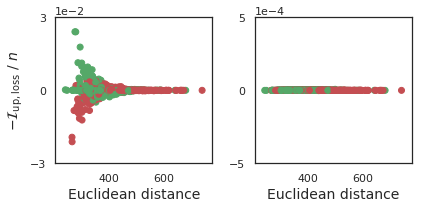

In [6]:
sns.set_style('white')
fontsize=14

fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6, 3))

num_train = len(flipped_idx)
color_vec = np.array(['g'] * num_train)
color_vec[flipped_idx] = 'r'
color_vec = list(color_vec)

axs[0].scatter(distances, rbf_predicted_loss_diffs, color=color_vec)
axs[0].set_ylim(-0.03, 0.03)
axs[0].set_yticks((-0.03, 0, 0.03))
axs[0].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[0].set_xlabel('Euclidean distance', fontsize=fontsize)
axs[0].set_ylabel('$-\mathcal{I}_\mathrm{up, loss} \ /\ n$', fontsize=fontsize)

axs[1].scatter(distances, inception_predicted_loss_diffs, color=color_vec)
axs[1].set_ylim(-0.0005, 0.0005)
axs[1].set_yticks((-0.0005, 0, 0.0005))
axs[1].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[1].set_xlabel('Euclidean distance', fontsize=fontsize)

plt.tight_layout()
# plt.savefig('figs/fig-rbf-dist.png', dpi=600, bbox_inches='tight')

Test image:
1.0 0.9613014 0.9998756647109985


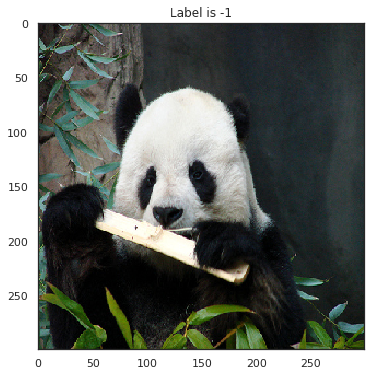

Top from RBF:
1327 1.0 300.08377 0.6901839 0.01123650656806098
1267 1.0 286.16025 0.9140903 0.01137655152214898
1224 1.0 294.23346 0.6840198 0.017794952392578126
672 1.0 278.25363 0.39304745 0.02405724631415473
1007 1.0 275.12842 0.83496577 0.02408842510647244


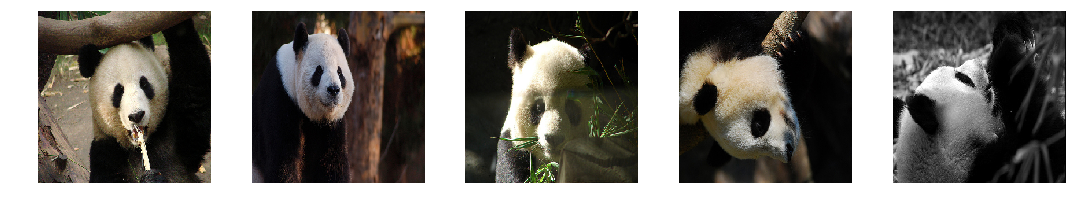

Top from Inception:
32 1.0 519.5575 2.0121114276763467e-06
1011 1.0 364.90137 2.131356547276179e-06
74 1.0 376.47607 2.4960948050849966e-06
17 1.0 477.09726 2.6511002538932694e-06
1113 1.0 497.79108 7.114876061677933e-06


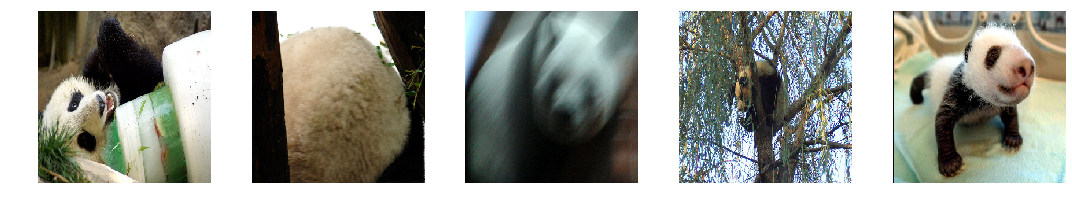

Dogs:
9 251 -1.0 425.68448 1.5014060772955417e-06
11 507 -1.0 457.2718 1.447323787336548e-06
13 75 -1.0 461.802 1.2646840574840705e-06
18 1016 -1.0 382.14117 1.028842978282935e-06
19 1648 -1.0 330.72647 9.925413825031784e-07


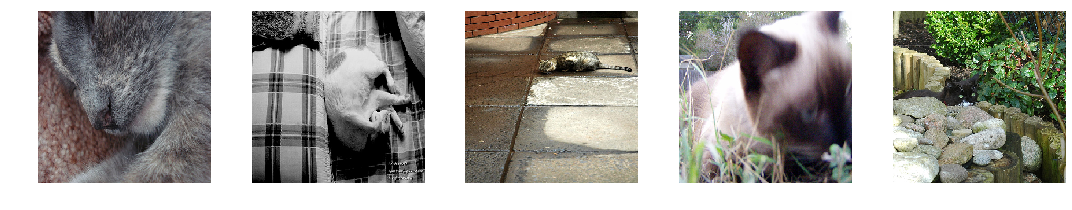

In [7]:
print('Test image:')
print(Y_test[test_idx], rbf_margins_test[test_idx], inception_Y_pred_correct[test_idx])
plot_flat_colorimage((X_test[test_idx, :] + 1) / 2, 0, side=299)
    
print('Top from RBF:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for counter, train_idx in enumerate(np.argsort(rbf_predicted_loss_diffs)[-5:]):
    print(train_idx, Y_train[train_idx], distances[train_idx], rbf_margins_train[train_idx], rbf_predicted_loss_diffs[train_idx])
    x_train = X_train[train_idx, :]
    axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
    axs[counter].axis('off')
plt.tight_layout()
# plt.savefig('figs/fig-rbf-fishes.png', dpi=600, bbox_inches='tight')
plt.show()

print('Top from Inception:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for counter, train_idx in enumerate(np.argsort(inception_predicted_loss_diffs)[-5:]):
    print(train_idx, Y_train[train_idx], distances[train_idx], inception_predicted_loss_diffs[train_idx])    
    x_train = X_train[train_idx, :]
    axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
    axs[counter].axis('off')
plt.tight_layout()
# plt.savefig('figs/fig-inception-fishes.png', dpi=600, bbox_inches='tight')
plt.show()

print('Dogs:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
counter = 4
for i, train_idx in enumerate(np.argsort(inception_predicted_loss_diffs)[:-50:-1]):
    if Y_train[train_idx] == -1.0:
        print(i, train_idx, Y_train[train_idx], distances[train_idx], inception_predicted_loss_diffs[train_idx])    
        x_train = X_train[train_idx, :]
        axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
        axs[counter].axis('off')
        counter -= 1
    if counter == -1:
        break
plt.tight_layout()
# plt.savefig('figs/fig-inception-dogs.png', dpi=600, bbox_inches='tight')
plt.show()